## FID Lab

The following is all the code used in the FID lab:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
pip freeze

anyio @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_anyio_1742243108/work
APScheduler @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_apscheduler_1732499160/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1733311059102/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1725356572528/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1733584251875/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
async-lru @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_async-lru_1742153708/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1741918516150/work
babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1738490167835/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1744783198182/work
bleach @ file:///home/conda/feedstock

In [4]:
# Styling for the plots
sns.set_theme(style="whitegrid", context="talk")

In [5]:
df = pd.read_csv("fid_data.csv")

Basic sanity check:

In [6]:
print(df.head())
print(df.dtypes)

   Observation_No        Species  Grass Neighbours    SD Treatment  FID  \
0             101  Laughing dove  False        NaN  11.0   control  2.0   
1             102  Laughing dove  False        NaN  11.0   control  0.5   
2             103    Common myna  False          G  12.1   control  4.0   
3             104    Common myna   True        NaN  11.9   control  6.6   
4             105  Laughing dove  False        NaN   9.7     angle  NaN   

   Immediate_flight  
0             False  
1             False  
2             False  
3             False  
4             False  
Observation_No        int64
Species              object
Grass                  bool
Neighbours           object
SD                  float64
Treatment            object
FID                 float64
Immediate_flight       bool
dtype: object


## Data viability

Mainly checking data encoding for analysis purposes, minor EDA:

In [7]:
df.isna().sum()

Observation_No       0
Species              0
Grass                0
Neighbours          32
SD                   0
Treatment            0
FID                  3
Immediate_flight     0
dtype: int64

<Axes: >

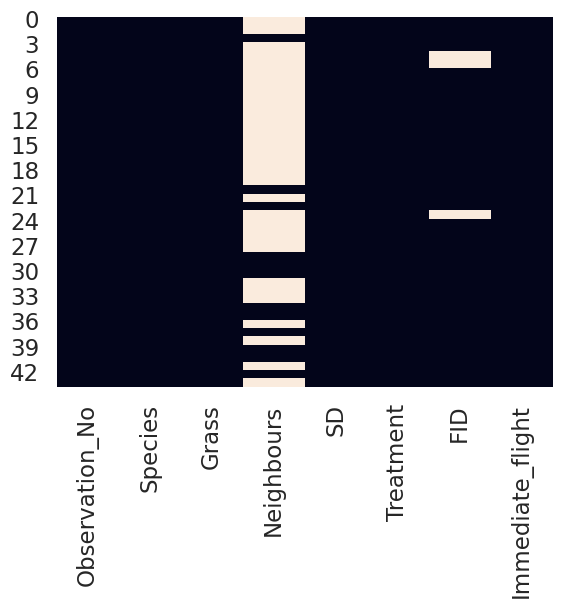

In [8]:
sns.heatmap(df.isna(), cbar=False)

Neighbours "None" means the bird was measured alone. FID "None" means the bird did not react.

In [9]:
df["FID"].describe()

count    41.000000
mean      3.595122
std       1.796378
min       0.500000
25%       2.000000
50%       3.500000
75%       4.400000
max       8.200000
Name: FID, dtype: float64

In [10]:
df["Species"].value_counts()

Species
Common myna        17
Monk parakeet      13
Eurasian hoopoe     8
Laughing dove       4
White wagtail       2
Name: count, dtype: int64

FID distances per species:

In [11]:
df_fid = df[df["FID"].notna()]

df_fid.groupby("Species")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Species,,,,,,,,
Common myna,16.0,4.093750,1.584706,1.8,3.325,4.15,4.600,7.6
Eurasian hoopoe,8.0,4.225000,1.842165,2.4,3.250,3.85,4.575,8.2
Laughing dove,2.0,1.250000,1.060660,0.5,0.875,1.25,1.625,2.0
Monk parakeet,13.0,2.469231,0.951652,1.0,1.800,2.50,3.000,4.5
White wagtail,2.0,6.750000,1.060660,6.0,6.375,6.75,7.125,7.5


FID distances by treatment:

In [12]:
df_fid.groupby("Treatment")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
angle,16.0,3.13125,1.464568,1.5,1.975,3.0,3.625,7.5
control,25.0,3.89200,1.949983,0.5,2.400,4.0,4.900,8.2


Percent of Immediate flight from all measurements:

In [13]:
df["Immediate_flight"].value_counts(normalize=True)

Immediate_flight
False    0.863636
True     0.136364
Name: proportion, dtype: float64

In [14]:
pd.crosstab(df["Species"], df["Immediate_flight"], normalize="index")

Immediate_flight,False,True
Species,,
Common myna,0.941176,0.058824
Eurasian hoopoe,0.875000,0.125000
Laughing dove,1.000000,0.000000
Monk parakeet,0.846154,0.153846
White wagtail,0.000000,1.000000


Some species were more or less resilient than others, and chose to fly away immediately, or to step aside (depending on their biology and other species dependent factors).

In [15]:
df["FID"].isna().mean()

np.float64(0.06818181818181818)

~6.8% of birds did not react (did not flee).

In [16]:
pd.crosstab(df["Treatment"], df["FID"].isna(), normalize="index")

FID,False,True
Treatment,,
angle,0.842105,0.157895
control,1.000000,0.000000


In [17]:
nonreact_df = (
    pd.crosstab(
        df["Treatment"],
        df["FID"].isna(),
        normalize="index"
    )
    .reset_index()
    .rename(columns={True: "No_flight", False: "Fled"})
)

nonreact_df

FID,Treatment,Fled,No_flight
0,angle,0.842105,0.157895
1,control,1.000000,0.000000


The 3 birds that did not flee were all from the angle treatment.

In [18]:
df["SD"].describe()

count    44.000000
mean     11.156818
std       1.590144
min       7.400000
25%      10.000000
50%      11.050000
75%      12.000000
max      14.800000
Name: SD, dtype: float64

In [19]:
df.groupby("Treatment")["SD"].describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
angle,19.0,11.010526,1.642794,8.6,9.85,10.7,11.8,14.5
control,25.0,11.268000,1.573669,7.4,10.00,11.8,12.0,14.8


No clear correlation between the treatment and the starting distance.

Grass vs FID:

In [20]:
df_fid.groupby("Grass")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Grass,,,,,,,,
False,7.0,2.857143,1.555482,0.5,2.0,2.40,4.100,4.9
True,34.0,3.747059,1.825449,1.0,2.5,3.55,4.475,8.2


Some difference, worth exploring further.

Neighbours:

In [21]:
df_fid["Neighbours"].value_counts(dropna=False)

Neighbours
NaN    29
G      10
P       2
Name: count, dtype: int64

No neighbours, the bird is part of a pair (P), the bird is part of a group (G).

## EDA

In [22]:
working_df = df.copy()

working_df["Day"] = np.select(
    [
        working_df["Observation_No"].between(101, 128),
        working_df["Observation_No"].between(229, 244)
    ],
    ["Day1", "Day2"],
    default="Other"
)

working_df["Day"].value_counts(dropna=False)
# For future data analysis:
df_fid = working_df[working_df["FID"].notna()]

In [23]:
pd.crosstab(working_df["Treatment"], working_df["FID"].notna(), margins=True)

FID,False,True,All
Treatment,,,
angle,3,16,19
control,0,25,25
All,3,41,44


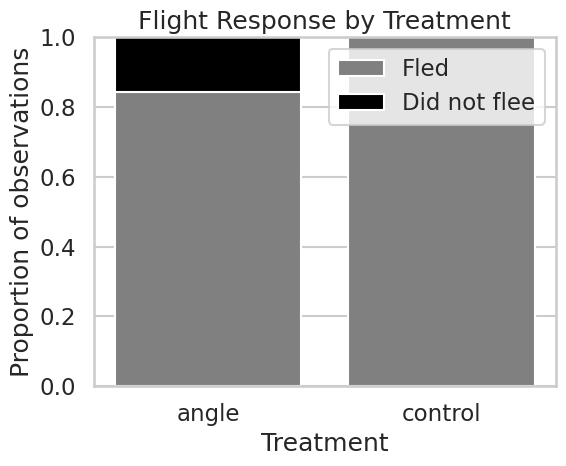

In [24]:
plt.figure(figsize=(6, 5))

plt.bar(
    nonreact_df["Treatment"],
    nonreact_df["Fled"],
    label="Fled",
    color="gray"
)

plt.bar(
    nonreact_df["Treatment"],
    nonreact_df["No_flight"],
    bottom=nonreact_df["Fled"],
    label="Did not flee",
    color="black"
)

plt.ylabel("Proportion of observations")
plt.xlabel("Treatment")
plt.title("Flight Response by Treatment")
plt.ylim(0, 1)

plt.legend()
plt.tight_layout()
plt.show()

First of, checking if the day of the observations influenced data collection (and thus creating a bias):

In [25]:
pd.crosstab(working_df["Species"], working_df["Day"])

Day,Day1,Day2
Species,,
Common myna,15,2
Eurasian hoopoe,4,4
Laughing dove,4,0
Monk parakeet,3,10
White wagtail,2,0


A clear shift in observed species % between the days.

In [26]:
pd.crosstab(working_df["Species"], working_df["Day"], normalize="columns")

Day,Day1,Day2
Species,,
Common myna,0.535714,0.125
Eurasian hoopoe,0.142857,0.250
Laughing dove,0.142857,0.000
Monk parakeet,0.107143,0.625
White wagtail,0.071429,0.000


In [27]:
working_df.groupby("Day")["Species"].nunique()

Day
Day1    5
Day2    3
Name: Species, dtype: int64

5 Species in day 1 as opposed to only 3 in day 2.

In [28]:
pd.crosstab(working_df["Day"], working_df["Immediate_flight"], normalize="index")

Immediate_flight,False,True
Day,,
Day1,0.892857,0.107143
Day2,0.812500,0.187500


There might have been a reason for the birds to be more wary and more likely to immediately fly away on the second day, or maybe the sample size is not big enough (28 day 1, 16 day 2).

In [29]:
pd.crosstab(working_df["Day"], working_df["FID"].isna(), normalize="index")

FID,False,True
Day,,
Day1,0.892857,0.107143
Day2,1.000000,0.000000


No birds decided to not react in day 2. Could be species underrepresentation, could be another reason.

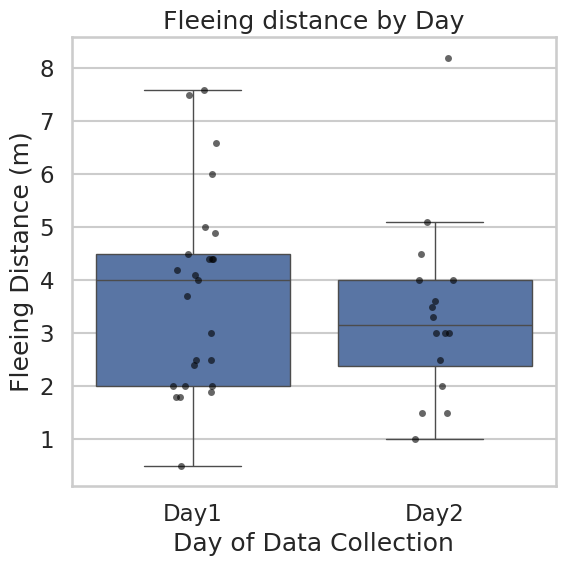

In [30]:
plt.figure(figsize=(6, 6))

sns.boxplot(
    data=df_fid,
    x="Day",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df_fid,
    x="Day",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Day of Data Collection")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing distance by Day")

plt.tight_layout()
plt.show()

Day 1 had more variability, and more birds were likelier to flee from further away (Could be species related).

In [31]:
df_fid.groupby(["Species", "Day"])["FID"].describe()

count      mean       std  min    25%   50%    75%  max
Species         Day                                                          
Common myna     Day1   14.0  4.135714  1.695971  1.8  2.875  4.30  4.800  7.6
                Day2    2.0  3.800000  0.282843  3.6  3.700  3.80  3.900  4.0
Eurasian hoopoe Day1    4.0  3.250000  0.967815  2.4  2.475  3.10  3.875  4.4
                Day2    4.0  5.200000  2.108712  3.5  3.875  4.55  5.875  8.2
Laughing dove   Day1    2.0  1.250000  1.060660  0.5  0.875  1.25  1.625  2.0
Monk parakeet   Day1    3.0  2.266667  0.642910  1.8  1.900  2.00  2.500  3.0
                Day2   10.0  2.530000  1.047802  1.0  1.625  2.75  3.000  4.5
White wagtail   Day1    2.0  6.750000  1.060660  6.0  6.375  6.75  7.125  7.5

Unclear correlation between measurement day + species to FID (samplesize is too small for clear joint comparison).

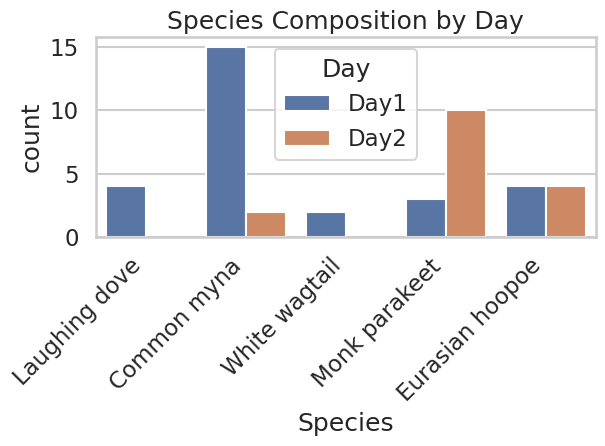

In [32]:
sns.countplot(data=working_df, x="Species", hue="Day")
plt.xticks(rotation=45, ha="right")
plt.title("Species Composition by Day")
plt.tight_layout()
plt.show()

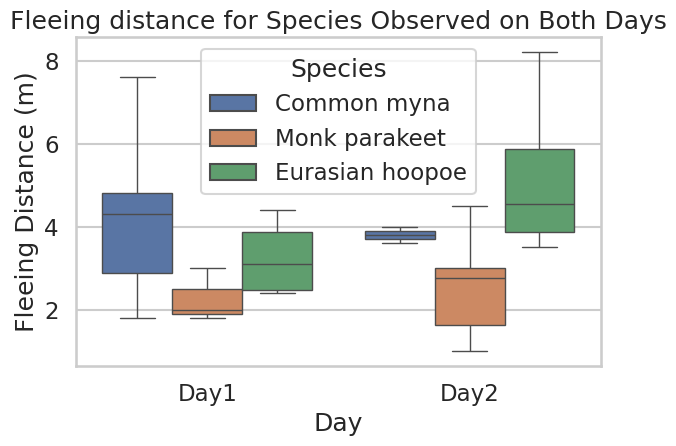

In [33]:
shared_species = (
    df_fid.groupby("Species")["Day"]
    .nunique()
    .loc[lambda x: x == 2]
    .index
)

df_shared = df_fid[df_fid["Species"].isin(shared_species)]

sns.boxplot(
    data=df_shared,
    x="Day",
    y="FID",
    hue="Species"
)
plt.title("Fleeing distance for Species Observed on Both Days")
plt.ylabel("Fleeing Distance (m)")
plt.tight_layout()
plt.show()

In [34]:
results = []

for sp, sub in df_shared.groupby("Species"):
    d1 = sub.loc[sub["Day"] == "Day1", "FID"].dropna().astype(float).values
    d2 = sub.loc[sub["Day"] == "Day2", "FID"].dropna().astype(float).values

    # Require at least 2 points per day for a minimally meaningful t-test
    if len(d1) < 2 or len(d2) < 2:
        results.append({
            "Species": sp, "n_Day1": len(d1), "n_Day2": len(d2),
            "t": np.nan, "p": np.nan, "note": "Insufficient n for Welch t-test (need >=2 per day)"
        })
        continue

    t, p = ttest_ind(d1, d2, equal_var=False)
    results.append({
        "Species": sp, "n_Day1": len(d1), "n_Day2": len(d2),
        "t": t, "p": p, "note": ""
    })

results_df = pd.DataFrame(results).sort_values("p", na_position="last")
results_df


,Species,n_Day1,n_Day2,t,p,note
1,Eurasian hoopoe,4,4,-1.680889,0.164502,
0,Common myna,14,2,0.677621,0.510429,
2,Monk parakeet,3,10,-0.529249,0.616738,


No significant difference for any species.

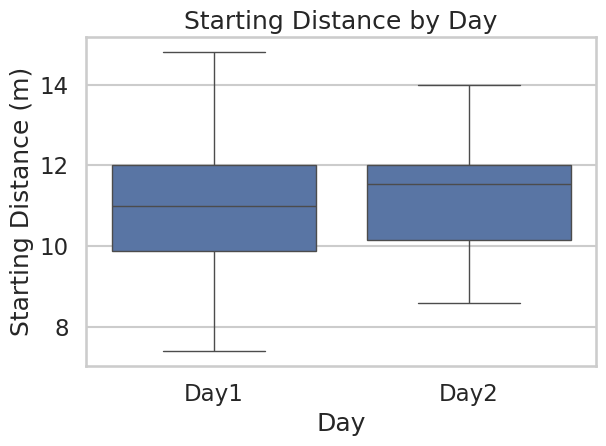

In [35]:
sns.boxplot(data=working_df, x="Day", y="SD")
plt.title("Starting Distance by Day")
plt.ylabel("Starting Distance (m)")
plt.tight_layout()
plt.show()

In [36]:
sd_day1 = working_df.loc[working_df["Day"] == "Day1", "SD"]
sd_day2 = working_df.loc[working_df["Day"] == "Day2", "SD"]

ttest_ind(sd_day1, sd_day2, equal_var=False)

TtestResult(statistic=np.float64(-0.38728082971914907), pvalue=np.float64(0.7008251672289597), df=np.float64(36.05327348651893))

No statistically significant difference between the two days.

Relationship between SD and FID:

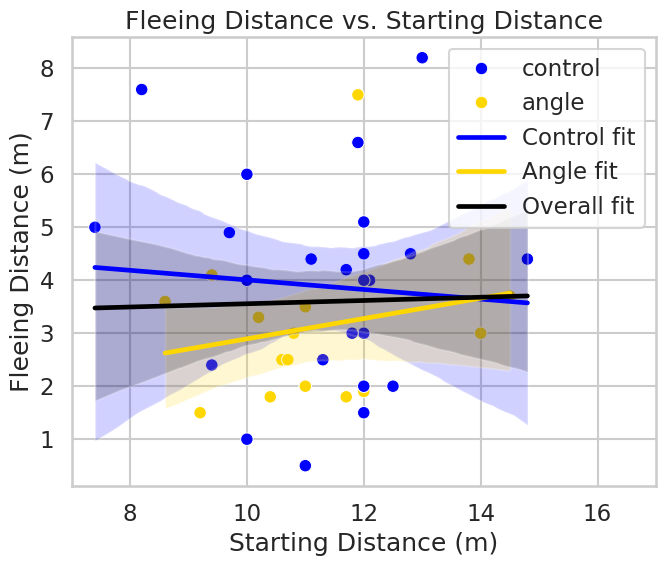

In [37]:
plt.figure(figsize=(7, 6))

# Scatter points
sns.scatterplot(
    data=df_fid,
    x="SD",
    y="FID",
    hue="Treatment",
    palette={
        "control": "blue",
        "angle": "gold"
    },
    alpha=1
)

# Control regression
sns.regplot(
    data=df_fid[df_fid["Treatment"] == "control"],
    x="SD",
    y="FID",
    scatter=False,
    color="blue",
    label="Control fit",
    ci=95
)

# Angle regression
sns.regplot(
    data=df_fid[df_fid["Treatment"] == "angle"],
    x="SD",
    y="FID",
    scatter=False,
    color="gold",
    label="Angle fit",
    ci=95
)

# Overall regression
sns.regplot(
    data=df_fid,
    x="SD",
    y="FID",
    scatter=False,
    color="black",
    label="Overall fit",
    ci=95
)

# ---- Reduce CI opacity ONLY (not scatter points) ----
ax = plt.gca()
for coll in ax.collections:
    if isinstance(coll, PolyCollection):
        coll.set_alpha(0.18)

# Axis formatting
plt.xlim(7, 17)
plt.xlabel("Starting Distance (m)")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance vs. Starting Distance")

# Legend placement
plt.legend(loc="upper right")

plt.tight_layout()
# plt.savefig("SD-FID.png", dpi=300)
plt.show()

All fits include a "Fleeing_Distance = constant" within their confidence interval, which means that even if Fleeing distance is dependant on Starting distance, it is weak and insignificant.

Distributional shape of FID:

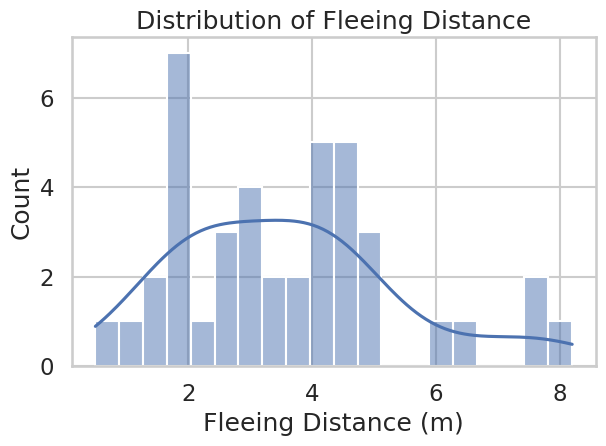

In [38]:
sns.histplot(df_fid["FID"], bins=20, kde=True)
plt.xlabel("Fleeing Distance (m)")
plt.title("Distribution of Fleeing Distance")
plt.tight_layout()
plt.show()

FID as a function of Species:

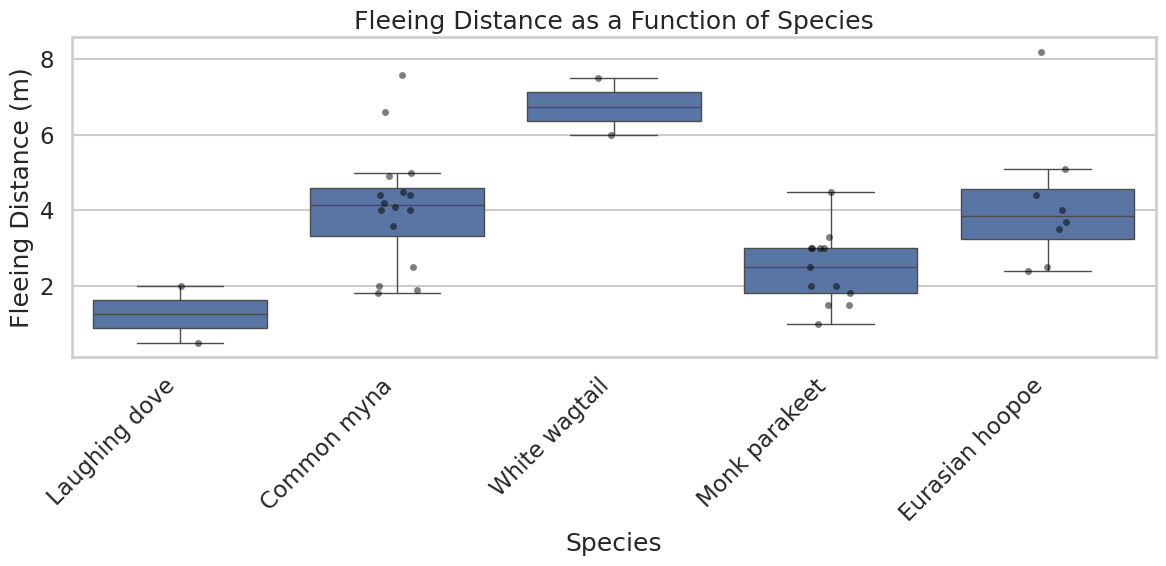

In [39]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x="Species",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df,
    x="Species",
    y="FID",
    color="black",
    alpha=0.5,
    jitter=True
)

plt.xlabel("Species")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance as a Function of Species")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Violin plots of species (distribution-focused):

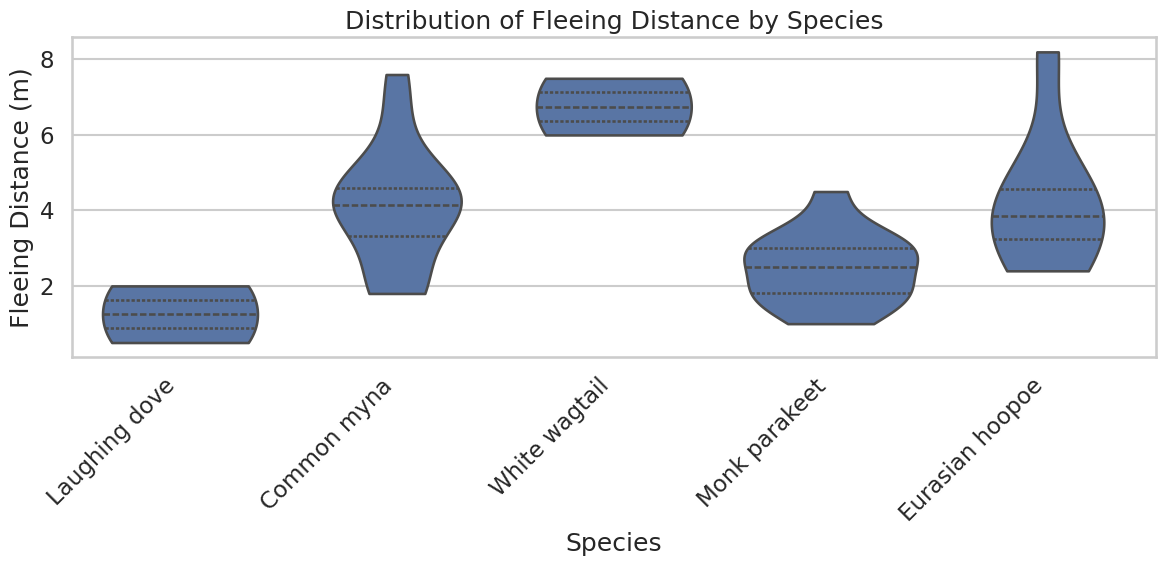

In [40]:
plt.figure(figsize=(12, 6))

sns.violinplot(
    data=df,
    x="Species",
    y="FID",
    inner="quartile",
    cut=0
)

plt.xlabel("Species")
plt.ylabel("Fleeing Distance (m)")
plt.title("Distribution of Fleeing Distance by Species")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Mean ± SE FID (Summary statistics):

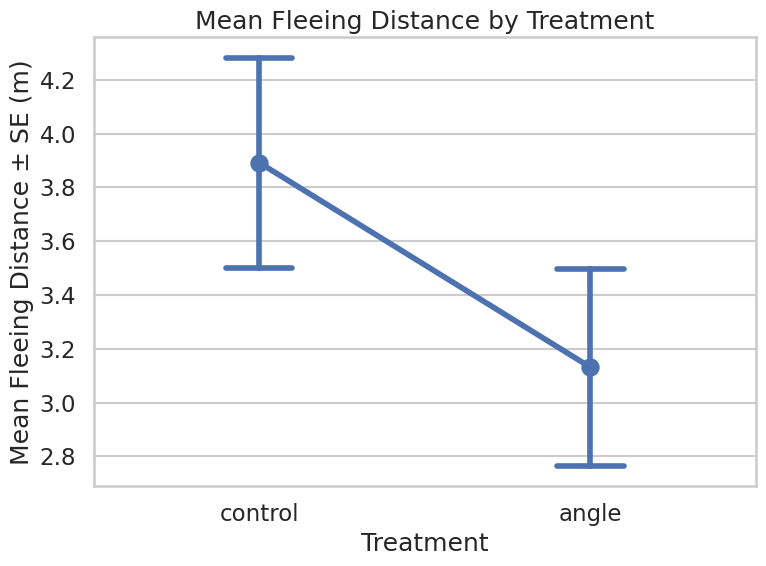

In [41]:
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=df,
    x="Treatment",
    y="FID",
    errorbar="se",
    capsize=0.2
)

plt.xlabel("Treatment")
plt.ylabel("Mean Fleeing Distance ± SE (m)")
plt.title("Mean Fleeing Distance by Treatment")

plt.tight_layout()
plt.show()

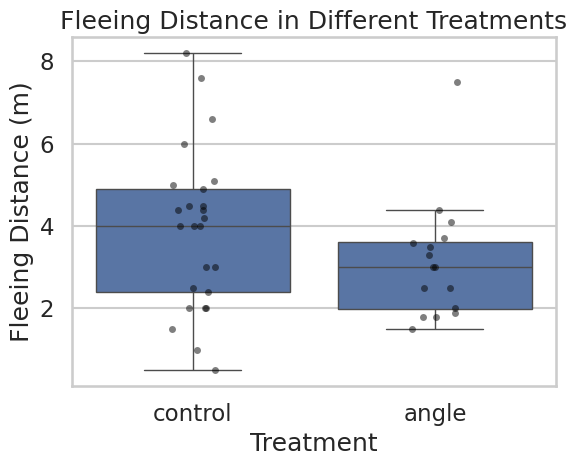

In [42]:
plt.figure(figsize=(6, 5))

sns.boxplot(
    data=df,
    x="Treatment",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df,
    x="Treatment",
    y="FID",
    color="black",
    alpha=0.5,
    jitter=True
)

plt.xlabel("Treatment")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance in Different Treatments")

plt.tight_layout()
plt.show()

## High FID analysis:

Some checks on FID > 5, since it happens (mostly) in just one of the treatments:

In [43]:
high_fid = working_df[working_df["FID"] > 5].copy()

high_fid.shape

(6, 9)

In [44]:
(working_df["FID"] > 5).mean()

np.float64(0.13636363636363635)

~13.6% of measurements.

In [45]:
high_fid["Observation_No"].tolist()

[104, 107, 111, 122, 233, 239]

In [46]:
high_fid["Species"].value_counts()

Species
Common myna        2
White wagtail      2
Eurasian hoopoe    2
Name: count, dtype: int64

In [47]:
high_fid["Species"].value_counts(normalize=True)

Species
Common myna        0.333333
White wagtail      0.333333
Eurasian hoopoe    0.333333
Name: proportion, dtype: float64

Each species of the above accounts for a third of the FID>5 measurements.

In [48]:
pd.crosstab(high_fid["Treatment"], columns="count")

col_0,count
Treatment,
angle,1
control,5


In [49]:
pd.crosstab(
    working_df["Treatment"],
    working_df["FID"] > 5,
    normalize="index"
)

FID,False,True
Treatment,,
angle,0.947368,0.052632
control,0.800000,0.200000


Considerably more common in the control group (20% of control group observations against 5% in the treatment group).

In [50]:
pd.crosstab(
    high_fid["Immediate_flight"],
    columns="count"
)

col_0,count
Immediate_flight,
False,3
True,3


In [51]:
df.assign(
    HighFID=df["FID"] > 5
).groupby("HighFID")["SD"].describe()

,count,mean,std,min,25%,50%,75%,max
HighFID,,,,,,,,
False,38.0,11.155263,1.589101,7.4,10.000,11.0,12.000,14.8
True,6.0,11.166667,1.748904,8.2,10.475,11.9,11.975,13.0


Doesn't look like the starting distance caused the FID to be high.

In [52]:
pd.crosstab(
    df["Grass"],
    df["FID"] > 5,
    normalize="index"
)

FID,False,True
Grass,,
False,1.000000,0.000000
True,0.828571,0.171429


All FID>5 measurements were measured on birds that were on grass and account for 17.1% of grass measurements.

In [53]:
high_fid["Neighbours"].value_counts(dropna=False)

Neighbours
NaN    6
Name: count, dtype: int64

All birds that have FID>5 were alone.

In [54]:
pd.crosstab(
    working_df["Day"],
    working_df["FID"] > 5,
    normalize="index"
)

FID,False,True
Day,,
Day1,0.857143,0.142857
Day2,0.875000,0.125000


FID>5 was measured on both days.

## Checking whether "Treatment" is an independent variable

The following is a test to see whether the treatment can be predicted from the results (FID) and the other data (metadata) columns, and whether it is different from predicting it from only the metadata columns:

In [55]:
df_fled = working_df[working_df["FID"].notna()]

df_fled.groupby("Treatment")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
angle,16.0,3.13125,1.464568,1.5,1.975,3.0,3.625,7.5
control,25.0,3.89200,1.949983,0.5,2.400,4.0,4.900,8.2


In [56]:
df_model = df_fled.copy()

In [57]:
y = df_model["Treatment"]

In [58]:
X = df_model[
    ["FID", "SD", "Species", "Grass", "Neighbours", "Day", "Immediate_flight"]
]

In [59]:
numeric_features = ["FID", "SD"]
categorical_features = ["Species", "Grass", "Neighbours", "Day"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

In [60]:
model = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000
)

In [61]:
clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ]
)

In [62]:
scores = cross_val_score(
    clf,
    X,
    y,
    cv=5,
    scoring="roc_auc"
)

scores, scores.mean()

/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(array([0.65      , 0.6       , 0.66666667, 0.46666667, 0.6       ]),
 np.float64(0.5966666666666667))

In [63]:
numeric_features_no_fid = ["SD"]
categorical_features_no_fid = ["Species", "Grass", "Neighbours", "Day", "Immediate_flight"]

preprocessor_no_fid = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_no_fid),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features_no_fid),
    ]
)

clf_no_fid = Pipeline(
    steps=[
        ("preprocess", preprocessor_no_fid),
        ("model", LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)),
    ]
)

X_no_fid = df_model[
    ["SD", "Species", "Grass", "Neighbours", "Day", "Immediate_flight"]
]

scores_no_fid = cross_val_score(clf_no_fid, X_no_fid, y, cv=5, scoring="roc_auc")

scores_no_fid, scores_no_fid.mean()

/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(array([0.45      , 0.33333333, 0.66666667, 0.46666667, 0.73333333]),
 np.float64(0.53))

In [64]:
auc1 = np.array([0.65, 0.60, 0.67, 0.47, 0.60])
auc2 = np.array([0.45, 0.33, 0.67, 0.47, 0.73])

def ci(x, alpha=0.05):
    return np.percentile(x, [100*alpha/2, 100*(1-alpha/2)])

print("Model 1 CI:", ci(auc1))
print("Model 2 CI:", ci(auc2))


Model 1 CI: [0.483 0.668]
Model 2 CI: [0.342 0.724]


When the model is not given the FID data, it has a chance similar to a coinflip (53% chance, high variability) of guessing right what treatment was used (which shows measured confounders are not obviously responsible for the treatment's effect). When given the FID data too, the model can better predict (60% chance, low variability) what treatment was used and thus showing that the correlation between result (FID) and treatment is NOT due to other factors.

But since there is strong overlap, the models do not differ from each other statistically.

## Data analysis + Results

Checking the effect of being observed on grass on fleeing distance:

In [65]:
df_plot = df_fled.copy() 
df_plot = df_plot[df_plot["FID"].notna()].copy()

# Grass is represented as a categorical value with nice labels
df_plot["Grass_label"] = df_plot["Grass"].map({True: "Grass", False: "No grass"})
order = ["No grass", "Grass"]

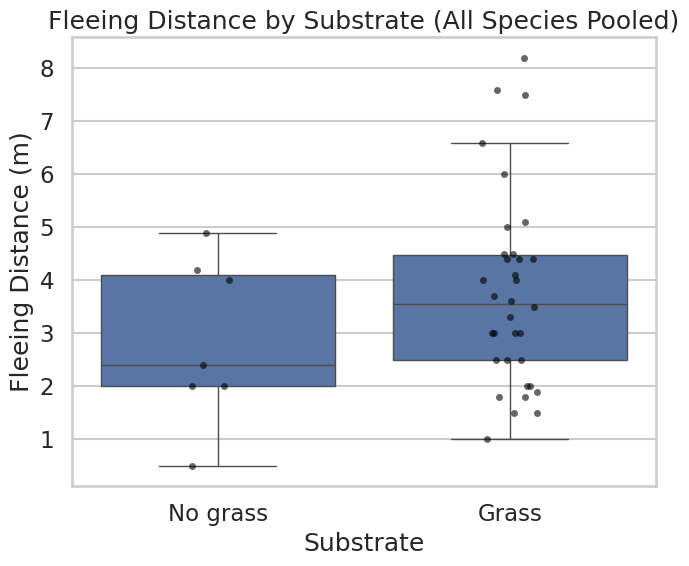

In [66]:
plt.figure(figsize=(7, 6))

sns.boxplot(
    data=df_plot,
    x="Grass_label",
    y="FID",
    order=order,
    showfliers=False
)

sns.stripplot(
    data=df_plot,
    x="Grass_label",
    y="FID",
    order=order,
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Substrate")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Substrate (All Species Pooled)")
plt.tight_layout()
plt.show()

In [67]:
top_species = (
    df_plot["Species"]
    .value_counts()
    .head(3)
    .index
    .tolist()
)
df_top = df_plot[df_plot["Species"].isin(top_species)].copy()
top_species

['Common myna', 'Monk parakeet', 'Eurasian hoopoe']

The others have 4 and 2 measurements only.

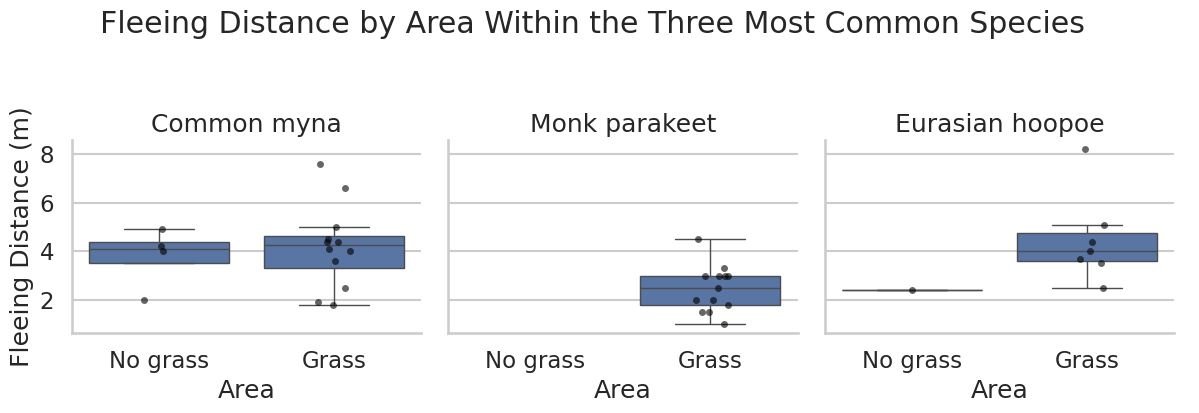

In [68]:
col_wrap = 3 

g = sns.catplot(
    data=df_top,
    x="Grass_label",
    y="FID",
    col="Species",
    col_wrap=col_wrap,
    kind="box",
    order=order,
    showfliers=False,
    height=4.0,
    aspect=1.0,
    sharey=True
)

# Overlay raw points
g.map_dataframe(
    sns.stripplot,
    x="Grass_label",
    y="FID",
    order=order,
    color="black",
    alpha=0.6,
    jitter=True
)

g.set_axis_labels("Area", "Fleeing Distance (m)")
g.set_titles("{col_name}")
g.fig.suptitle(
    "Fleeing Distance by Area Within the Three Most Common Species",
    y=1.05
)

plt.tight_layout()
plt.show()

Within mynas looks similar. Within the other species (the omitted ones too), There aren't enough measurements in both classifications to claim there is a difference.

Myna only graph:

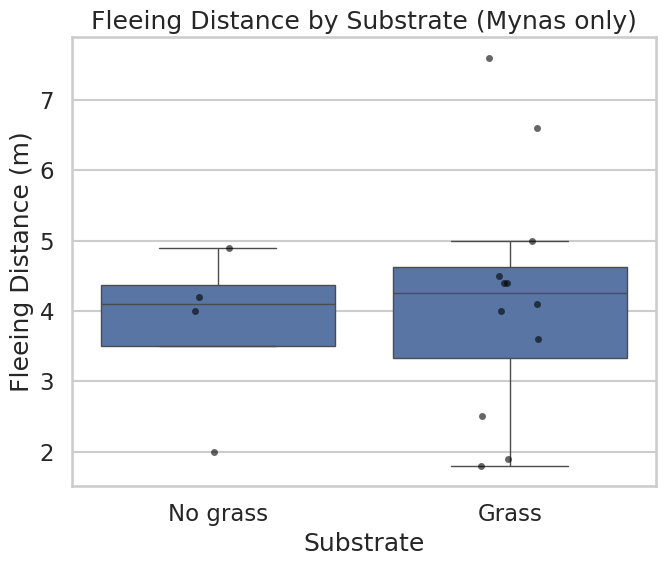

In [69]:
Mynas = ( # Would get Mynas since they are the most common species
    df_plot["Species"]
    .value_counts()
    .head(1)
    .index
    .tolist()
)
df_mynas = df_plot[df_plot["Species"].isin(Mynas)].copy()

plt.figure(figsize=(7, 6))

sns.boxplot(
    data=df_mynas,
    x="Grass_label",
    y="FID",
    order=order,
    showfliers=False
)

# Overlay raw points
sns.stripplot(
    data=df_mynas,
    x="Grass_label",
    y="FID",
    order=order,
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Substrate")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Substrate (Mynas only)")
plt.tight_layout()
plt.show()

Checking the effect of Neighbours and species on Fleeing distance, both individually and jointly:

In [70]:
df_plot = df_fled.copy()
df_plot = df_plot[df_plot["FID"].notna()].copy()

df_plot["Neighbours_label"] = np.where(
    df_plot["Neighbours"].isna(),
    "Alone",
    df_plot["Neighbours"].map({"P": "Pair", "G": "Group"})
)

print(df_plot["Neighbours_label"].value_counts(dropna=False))


preferred_order = ["Alone", "Pair", "Group"]
order = [c for c in preferred_order if c in set(df_plot["Neighbours_label"].dropna())]

print("Using order:", order)


Neighbours_label
Alone    29
Group    10
Pair      2
Name: count, dtype: int64
Using order: ['Alone', 'Pair', 'Group']


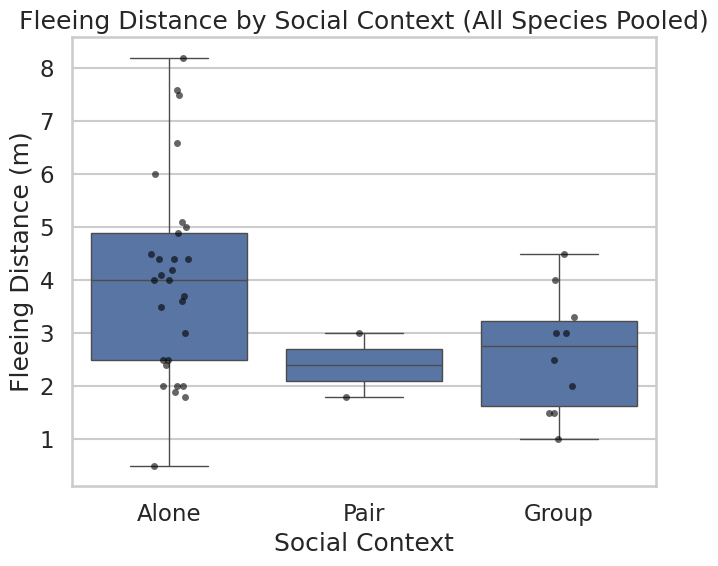

In [71]:
plt.figure(figsize=(7, 6))

sns.boxplot(
    data=df_plot,
    x="Neighbours_label",
    y="FID",
    order=order,
    showfliers=False
)

sns.stripplot(
    data=df_plot,
    x="Neighbours_label",
    y="FID",
    order=order,
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Social Context")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Social Context (All Species Pooled)")

plt.tight_layout()
plt.show()

In [72]:
groups = [
    g["FID"].values
    for _, g in df_plot.groupby("Neighbours_label")
    if len(g) >= 2
]

f_oneway(*groups)

F_onewayResult(statistic=np.float64(2.915356636884702), pvalue=np.float64(0.06638899752979217))

P=0.066 means no statistically significant difference between the groups.

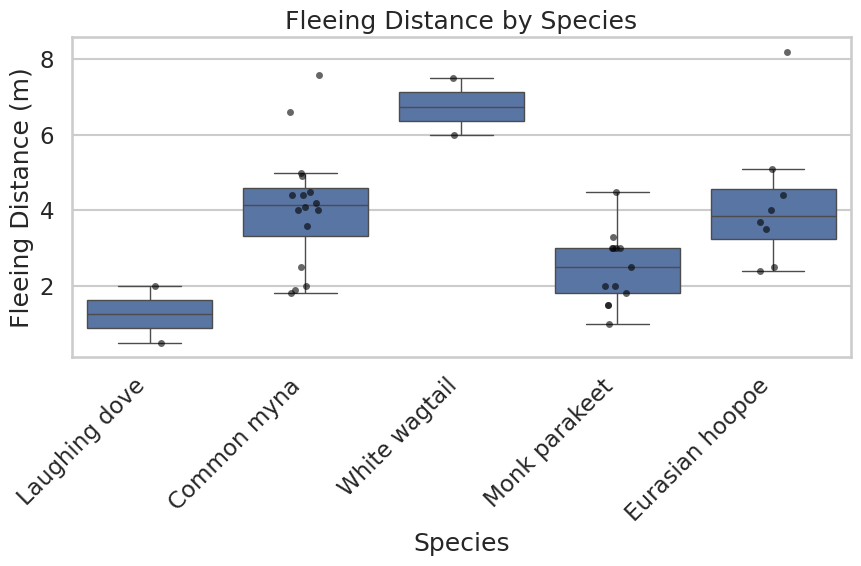

In [73]:
plt.figure(figsize=(9, 6))

sns.boxplot(
    data=df_plot,
    x="Species",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df_plot,
    x="Species",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Species")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Species")

plt.tight_layout()
plt.show()

In [74]:
groups = [
    g["FID"].values
    for _, g in df_plot.groupby("Species")
    if len(g) >= 2
]

f_oneway(*groups)

F_onewayResult(statistic=np.float64(6.584639136944267), pvalue=np.float64(0.00043911882829139235))

p<0.001 shows that at least one group differs from the others (With the variance between groups getting to up to 6 from the difference within groups).

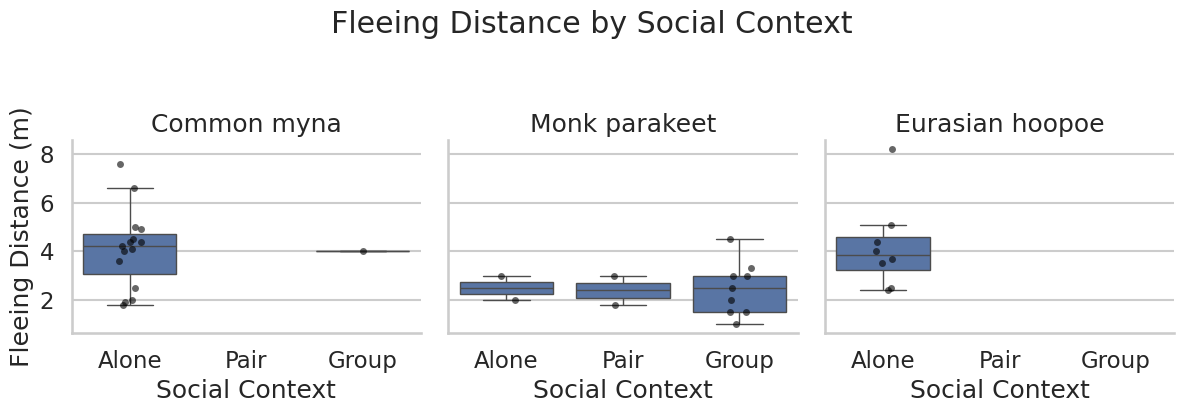

In [75]:
top_species = (
    df_plot["Species"]
    .value_counts()
    .head(3)
    .index
)

df_joint = df_plot[df_plot["Species"].isin(top_species)].copy()

g = sns.catplot(
    data=df_joint,
    x="Neighbours_label",
    y="FID",
    col="Species",
    col_wrap=3,
    kind="box",
    order=order,
    showfliers=False,
    height=4.0,
    aspect=1.0,
    sharey=True
)

g.map_dataframe(
    sns.stripplot,
    x="Neighbours_label",
    y="FID",
    order=order,
    color="black",
    alpha=0.6,
    jitter=True
)

g.set_axis_labels("Social Context", "Fleeing Distance (m)")
g.set_titles("{col_name}")
g.fig.suptitle(
    "Fleeing Distance by Social Context",
    y=1.05
)

plt.tight_layout()
plt.show()


Checking Immediate Flight choice based on day (and effect on Fleeing distance):

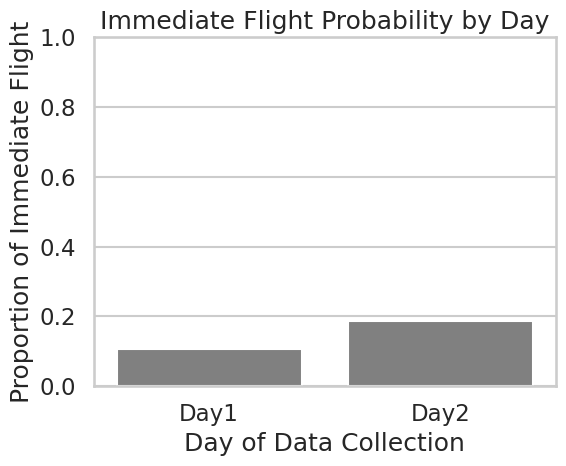

In [76]:
imm_rate = (
    working_df
    .groupby("Day")["Immediate_flight"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 5))

sns.barplot(
    data=imm_rate,
    x="Day",
    y="Immediate_flight",
    color="gray"
)

plt.ylabel("Proportion of Immediate Flight")
plt.xlabel("Day of Data Collection")
plt.ylim(0, 1)
plt.title("Immediate Flight Probability by Day")

plt.tight_layout()
plt.show()


In [77]:
df_immediate = working_df[
    (working_df["Immediate_flight"] == True) &
    (working_df["FID"].notna())
].copy()

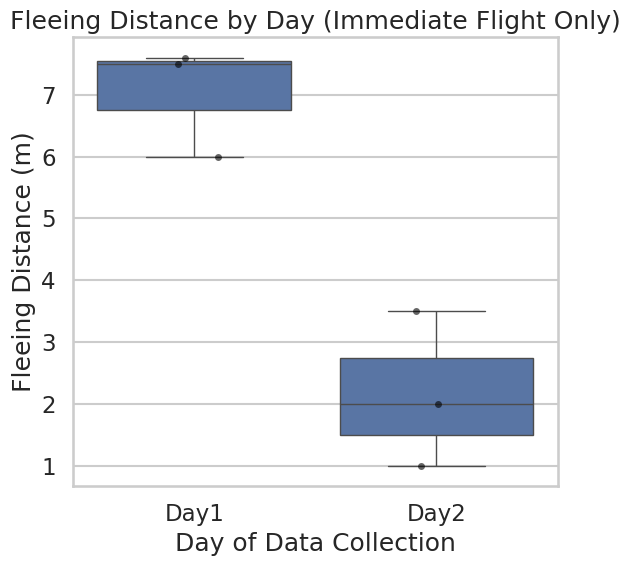

In [78]:
plt.figure(figsize=(6, 6))

sns.boxplot(
    data=df_immediate,
    x="Day",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df_immediate,
    x="Day",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Day of Data Collection")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Day (Immediate Flight Only)")

plt.tight_layout()
plt.show()

/tmp/ipykernel_11327/155670870.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


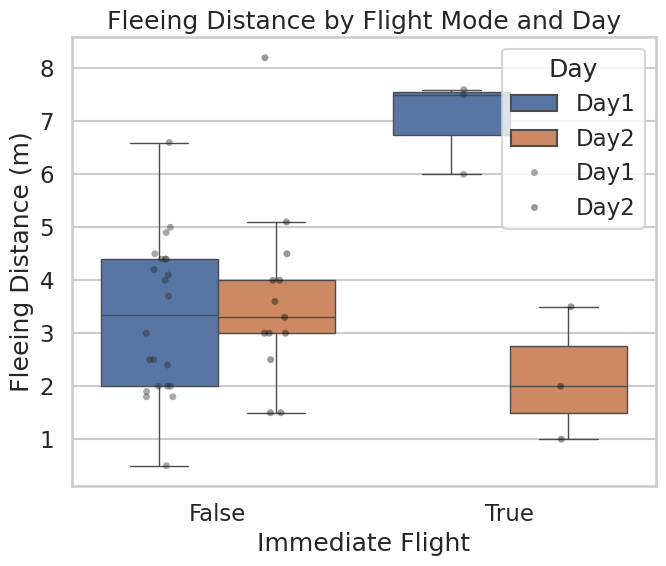

In [79]:
df_fled = working_df[working_df["FID"].notna()].copy()

plt.figure(figsize=(7, 6))

sns.boxplot(
    data=df_fled,
    x="Immediate_flight",
    y="FID",
    hue="Day",
    showfliers=False
)

sns.stripplot(
    data=df_fled,
    x="Immediate_flight",
    y="FID",
    hue="Day",
    dodge=True,
    color="black",
    alpha=0.4,
    jitter=True
)

plt.xlabel("Immediate Flight")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Flight Mode and Day")

plt.legend(title="Day", loc="upper right")
plt.tight_layout()
plt.show()

Checking Immediate Flight choice based on species (and effect on Fleeing distance):

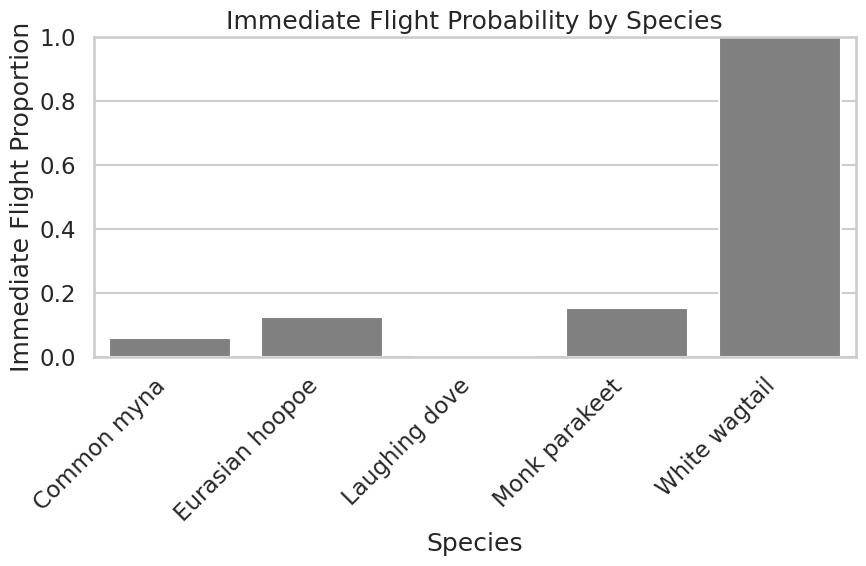

In [80]:
imm_by_species = (
    working_df
    .groupby("Species")["Immediate_flight"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(9, 6))

sns.barplot(
    data=imm_by_species,
    x="Species",
    y="Immediate_flight",
    color="gray"
)

plt.ylabel("Immediate Flight Proportion")
plt.xlabel("Species")
plt.ylim(0, 1)
plt.title("Immediate Flight Probability by Species")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [81]:
df_immediate = working_df[
    (working_df["Immediate_flight"] == True) &
    (working_df["FID"].notna())
].copy()

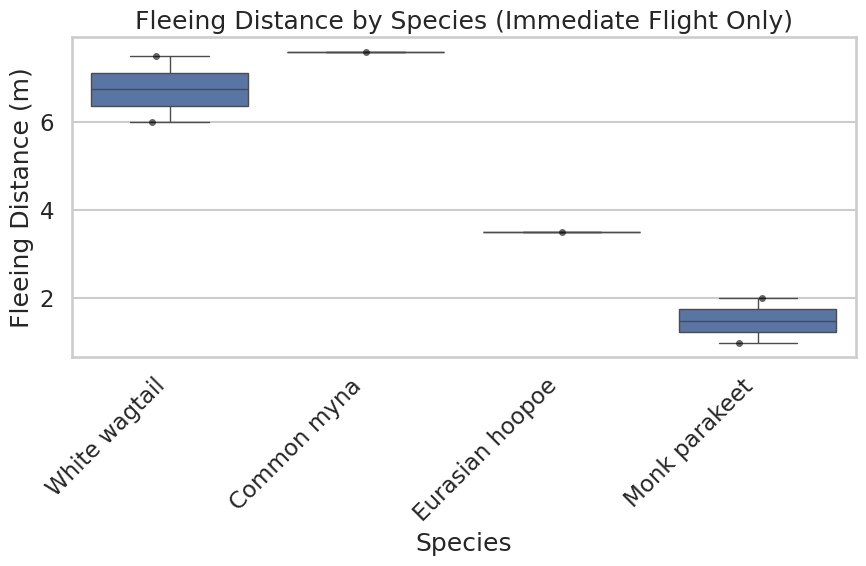

In [82]:
plt.figure(figsize=(9, 6))

sns.boxplot(
    data=df_immediate,
    x="Species",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df_immediate,
    x="Species",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Species")
plt.ylabel("Fleeing Distance (m)")
plt.title("Fleeing Distance by Species (Immediate Flight Only)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [83]:
species_both_days = (
    df_immediate
    .groupby("Species")["Day"]
    .nunique()
    .loc[lambda x: x == 2]
    .index
)

df_joint = df_immediate[df_immediate["Species"].isin(species_both_days)].copy()

In [84]:
g = sns.catplot(
    data=df_joint,
    x="Day",
    y="FID",
    col="Species",
    col_wrap=3,
    kind="box",
    showfliers=False,
    height=4.0,
    aspect=1.0,
    sharey=True
)

g.map_dataframe(
    sns.stripplot,
    x="Day",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

g.set_axis_labels("Day of Data Collection", "Flight Initiation Distance (m)")
g.set_titles("{col_name}")
g.fig.suptitle(
    "FID by Day Within Species (Immediate Flight Only)",
    y=1.05
)

plt.tight_layout()
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x0 with 0 Axes>

In [85]:
print("Immediate-flight, FID-present rows:", len(df_immediate))

print("\nDays present in df_immediate:")
print(df_immediate["Day"].value_counts(dropna=False))

print("\nSpecies counts by Day in df_immediate:")
print(pd.crosstab(df_immediate["Species"], df_immediate["Day"], dropna=False))


Immediate-flight, FID-present rows: 6

Days present in df_immediate:
Day
Day1    3
Day2    3
Name: count, dtype: int64

Species counts by Day in df_immediate:
Day              Day1  Day2
Species                    
Common myna         1     0
Eurasian hoopoe     0     1
Monk parakeet       0     2
White wagtail       2     0


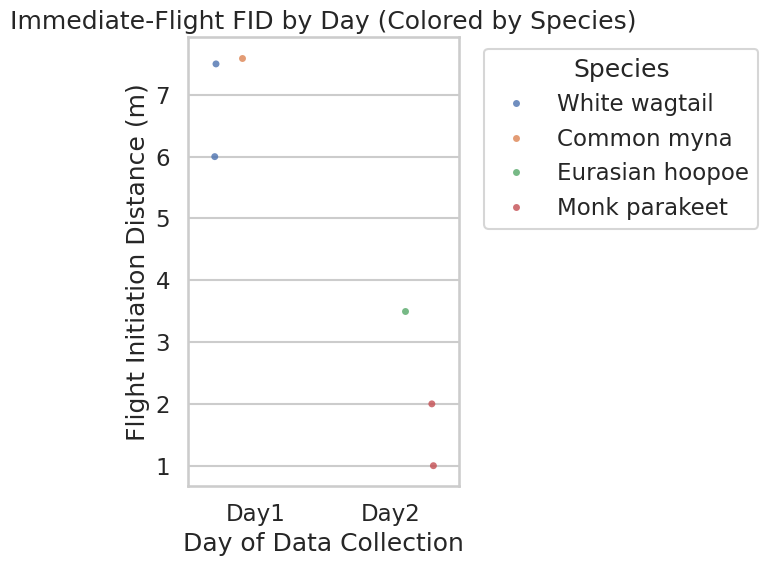

In [86]:
plt.figure(figsize=(7, 6))

sns.stripplot(
    data=df_immediate,
    x="Day",
    y="FID",
    hue="Species",
    dodge=True,
    jitter=True,
    alpha=0.8
)

plt.xlabel("Day of Data Collection")
plt.ylabel("Flight Initiation Distance (m)")
plt.title("Immediate-Flight FID by Day (Colored by Species)")
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


The apparent difference in FID between days among immediate-flight responses is explained by differences in species composition; within-species day comparisons were not possible due to lack of overlap.

And lastly, and most importantly...

In [87]:
df_plot = df_fled.copy()

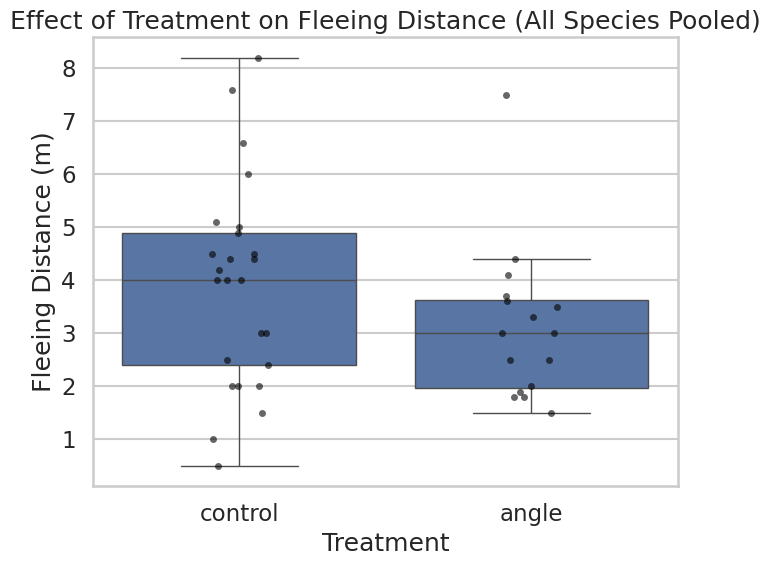

In [88]:
plt.figure(figsize=(7, 6))

sns.boxplot(
    data=df_plot,
    x="Treatment",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df_plot,
    x="Treatment",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

plt.xlabel("Treatment")
plt.ylabel("Fleeing Distance (m)")
plt.title("Effect of Treatment on Fleeing Distance (All Species Pooled)")

plt.tight_layout()
plt.show()

In [89]:
ctrl = df_plot.loc[df_plot["Treatment"] == "control", "FID"]
angle = df_plot.loc[df_plot["Treatment"] == "angle", "FID"]

ttest_ind(ctrl, angle, equal_var=False)

TtestResult(statistic=np.float64(1.4221309890958922), pvalue=np.float64(0.16317188097771967), df=np.float64(37.874448953920606))

Not significantly different.

In [90]:
top_species

Index(['Common myna', 'Monk parakeet', 'Eurasian hoopoe'], dtype='object', name='Species')

In [91]:
df_top = df_plot[df_plot["Species"].isin(top_species)].copy()

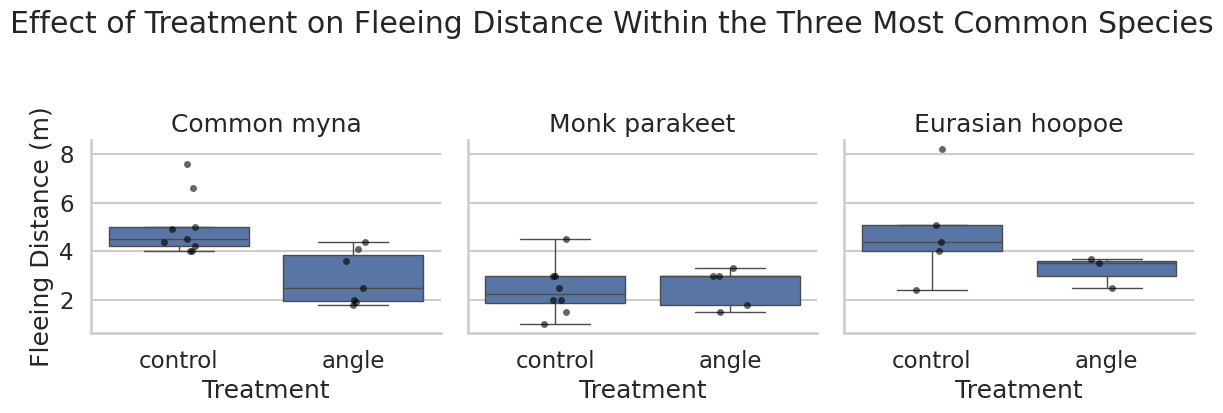

In [92]:
g = sns.catplot(
    data=df_top,
    x="Treatment",
    y="FID",
    col="Species",
    col_wrap=3,
    kind="box",
    showfliers=False,
    height=4.0,
    aspect=1.0,
    sharey=True
)

g.map_dataframe(
    sns.stripplot,
    x="Treatment",
    y="FID",
    color="black",
    alpha=0.6,
    jitter=True
)

g.set_axis_labels("Treatment", "Fleeing Distance (m)")
g.set_titles("{col_name}")
g.fig.suptitle(
    "Effect of Treatment on Fleeing Distance Within the Three Most Common Species",
    y=1.05
)

plt.tight_layout()
plt.show()

In [93]:
for sp, sub in df_top.groupby("Species"):
    ctrl = sub.loc[sub["Treatment"] == "control", "FID"]
    angle = sub.loc[sub["Treatment"] == "angle", "FID"]

    if len(ctrl) >= 2 and len(angle) >= 2:
        print(sp, ttest_ind(ctrl, angle, equal_var=False))
    else:
        print(sp, "insufficient data")

Common myna TtestResult(statistic=np.float64(3.5877300832096983), pvalue=np.float64(0.0030617805859020934), df=np.float64(13.70778311141726))
Eurasian hoopoe TtestResult(statistic=np.float64(1.5497734766851048), pvalue=np.float64(0.18108613031723175), df=np.float64(5.070072800916479))
Monk parakeet TtestResult(statistic=np.float64(-0.15642420667443083), pvalue=np.float64(0.8786752590260292), df=np.float64(10.46517075924411))


p(Common myna)= 0.003, p(Eurasian hoopoe)= 0.18, p(Monk parakeet)= 0.88

Which means only the myna was statistically different between treatments, the other two birds showed no statistically significant difference.

Laughing doves graph:

In [94]:
working = df.copy()
working["Fled"] = working["FID"].notna()


summary = (
    working
    .groupby(["Species", "Treatment"])
    .agg(
        n=("Fled", "size"),
        n_fled=("Fled", "sum"),
        n_no_flight=("Fled", lambda s: (~s).sum()),
        prop_fled=("Fled", "mean")
    )
    .reset_index()
)

summary.head()


pivot = summary.pivot(index="Species", columns="Treatment", values=["n", "n_no_flight", "prop_fled"])
pivot.head()


treated_name = "angle"   # change if needed
control_name = "control" # change if needed

species_strict = pivot.index[
    (pivot[("prop_fled", treated_name)] == 0) &
    (pivot[("n", treated_name)] > 0) &
    (pivot[("prop_fled", control_name)] > 0) &
    (pivot[("n", control_name)] > 0)
].tolist()

species_strict


species_partial = pivot.index[
    (pivot[("n_no_flight", treated_name)] >= 1) &
    (pivot[("n", treated_name)] > 0) &
    (pivot[("prop_fled", control_name)] > 0) &
    (pivot[("n", control_name)] > 0)
].tolist()

species_partial

['Common myna', 'Laughing dove']

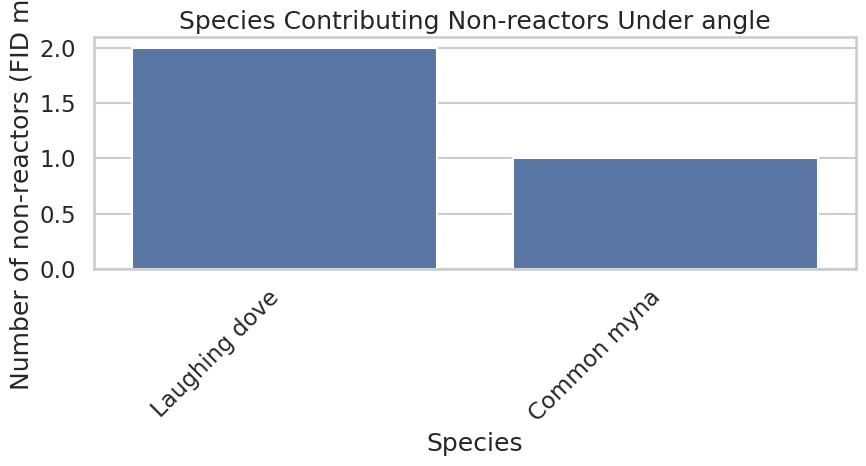

In [95]:
no_flight_treated = (
    working[working["Treatment"] == treated_name]
    .groupby("Species")["Fled"]
    .apply(lambda s: (~s).sum())
    .reset_index(name="n_no_flight")
    .sort_values("n_no_flight", ascending=False)
)

# Keep only species with at least 1 non-reactor under treatment
no_flight_treated = no_flight_treated[no_flight_treated["n_no_flight"] > 0]

plt.figure(figsize=(9, 5))
sns.barplot(data=no_flight_treated, x="Species", y="n_no_flight")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Species")
plt.ylabel("Number of non-reactors (FID missing)")
plt.title(f"Species Contributing Non-reactors Under {treated_name}")
plt.tight_layout()
plt.show()

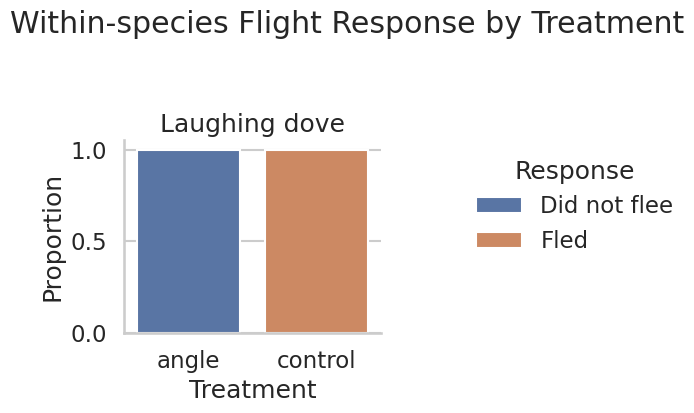

In [96]:
species_to_show = species_strict if len(species_strict) > 0 else species_partial
species_to_show


plot_df = (
    working[working["Species"].isin(species_to_show)]
    .groupby(["Species", "Treatment"])["Fled"]
    .value_counts(normalize=True)
    .rename("prop")
    .reset_index()
)

plot_df["Response"] = plot_df["Fled"].map({True: "Fled", False: "Did not flee"})
plot_df.head()


g = sns.catplot(
    data=plot_df,
    x="Treatment",
    y="prop",
    hue="Response",
    col="Species",
    col_wrap=2,
    kind="bar",
    height=4,
    aspect=0.6,
    sharey=True
)

g.set_axis_labels("Treatment", "Proportion")
g.set_titles("{col_name}")
g.fig.suptitle("Within-species Flight Response by Treatment", y=1.05)

plt.tight_layout()
plt.show()
